In [1]:
import pandas as pd
import theano.tensor as tt
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np


In [2]:
df = pd.read_csv('/Users/Berkay/Downloads/recruitment_challenge-master/DataScience_202209/MMM_test_data.csv')

In [3]:
import datetime
from dateutil.parser import parse

def change_date(x):

    datetime.datetime.strptime(x, '%d-%m-%y')
    return parse(x, dayfirst=True)

df.start_of_week = df.start_of_week.apply(lambda x: change_date(x))

df = df.set_index('start_of_week')


In [32]:
df.head()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
start_of_week,,,,,,,,
2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
2020-09-06,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


<ipython-input-5-fa856aec35e8>:42: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(1000, step=step, start=start)
/Users/Berkay/.local/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [b_trend]
>Metropolis: [b_seasonal]
>Metropolis: [a]
>Metropolis: [adstock]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
<ipython-input-5-fa856aec35e8>:45: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/Users/Berkay/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


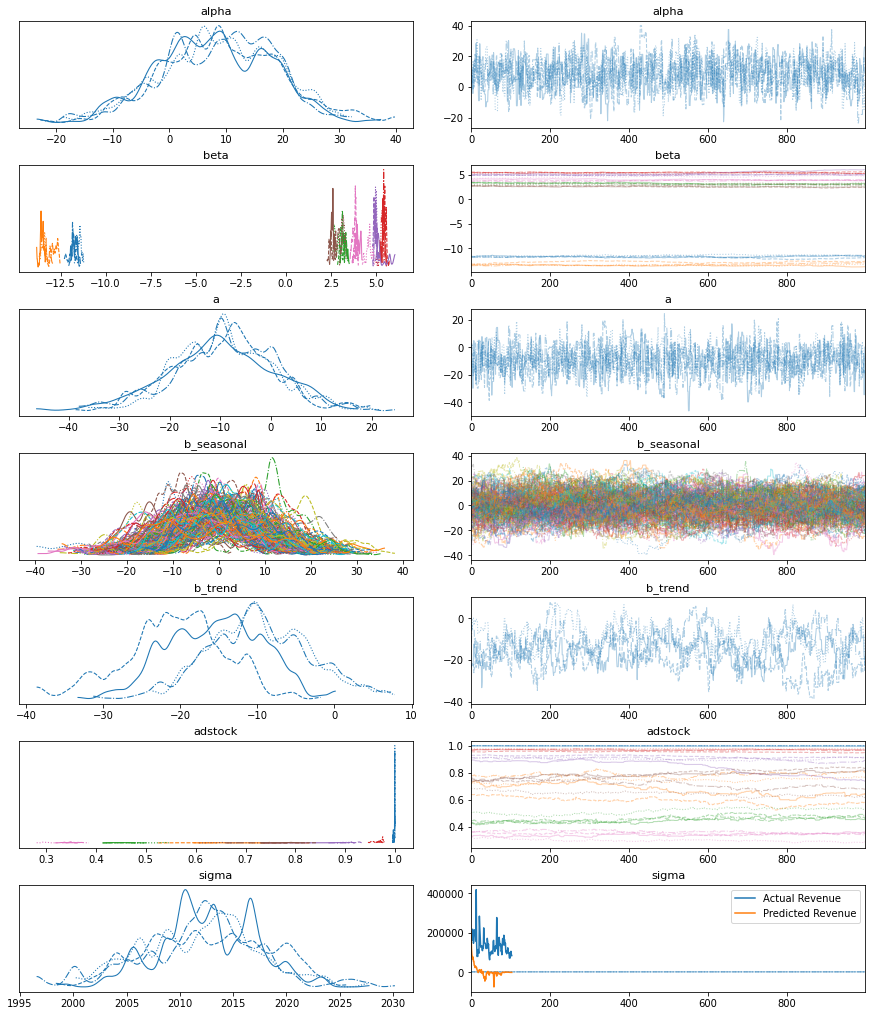

In [5]:
import pymc3 as pm
import pandas as pd
import numpy as np

data = df
n_channels = 7
n_weeks = len(data)

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=n_channels)
    
    adstock = pm.Uniform('adstock', lower=0, upper=1, shape=n_channels, testval=np.ones(n_channels)*0.5)
    
    #Seasonality and trend
    a = pm.Normal('a', mu=0, sd=10)
    b_seasonal = pm.Normal('b_seasonal', mu=0, sd=10, shape=52, testval=np.zeros(52))
    b_trend = pm.Normal('b_trend', mu=0, sd=10)
    
    mu = alpha + b_trend * np.arange(n_weeks) + a * np.cos(np.arange(n_weeks) / 52 * 2 * np.pi) + \
         pm.math.dot(data.iloc[:, 1:], beta * adstock)
    sigma = pm.HalfNormal('sigma', sd=10)
    revenue = pm.Normal('revenue', mu=mu, sd=sigma, observed=data.iloc[:, 0])
    
    step = pm.Metropolis()
    start = pm.find_MAP()
    trace = pm.sample(1000, step=step, start=start)

pm.traceplot(trace)

# Get posterior means
means = {'alpha': trace['alpha'].mean(), 'beta': trace['beta'].mean(axis=0), 
         'adstock': trace['adstock'].mean(axis=0), 'a': trace['a'].mean(), 
         'b_seasonal': trace['b_seasonal'].mean(axis=0), 'b_trend': trace['b_trend'].mean()}

weeks = np.arange(n_weeks)
spend = data.iloc[:, 1:].values

predictions = pd.DataFrame({'week': weeks, 'revenue': np.zeros(n_weeks)})

for i in range(n_channels):
    predictions['revenue'] += spend[:, i] * means['beta'][i] * np.power(means['adstock'][i], weeks)

predictions['revenue'] += means['a'] * np.cos(weeks / 52 * 2 * np.pi) + means['b_trend'] * weeks

# Plot predictions vs actual revenue
import matplotlib.pyplot as plt
plt.plot(weeks, data.iloc[:, 0], label='Actual Revenue')
plt.plot(predictions['week'], predictions['revenue'], label='Predicted Revenue')
plt.legend()
plt.show()


In [31]:
#Model Performance
waic = pm.waic(trace)
print('Watanabe-Akaike information criterion:', waic.waic)

/Users/Berkay/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Watanabe-Akaike information criterion: -26231.322093623596


/Users/Berkay/.local/lib/python3.8/site-packages/arviz/stats/stats.py:1466: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [6]:
summary_df= pm.summary(trace)

/Users/Berkay/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [11]:
summary_df.head(50)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,8.627,10.100,-10.257,26.929,0.342,0.270,874.0,700.0,859.0,902.0,1.00
beta[0],-11.702,0.211,-12.038,-11.247,0.085,0.064,6.0,6.0,6.0,15.0,1.75
beta[1],-13.289,0.315,-13.641,-12.619,0.145,0.110,5.0,5.0,6.0,28.0,1.90
beta[2],3.110,0.215,2.663,3.417,0.101,0.077,4.0,4.0,5.0,14.0,2.48
beta[3],5.426,0.106,5.234,5.611,0.038,0.028,8.0,8.0,7.0,27.0,1.55
beta[4],5.082,0.255,4.844,5.764,0.116,0.087,5.0,5.0,5.0,12.0,2.09
beta[5],2.805,0.275,2.397,3.288,0.133,0.101,4.0,4.0,5.0,12.0,2.91
beta[6],4.076,0.346,3.583,4.721,0.166,0.127,4.0,4.0,5.0,12.0,2.55
a,-9.261,10.123,-29.003,9.216,0.328,0.244,950.0,861.0,953.0,751.0,1.00
b_seasonal[0],-1.563,10.261,-22.152,16.507,1.898,1.356,29.0,29.0,29.0,28.0,1.10


In [10]:
summary_df.tail(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b_seasonal[41],-0.858,10.204,-17.834,20.656,3.327,2.430,9.0,9.0,10.0,17.0,1.37
b_seasonal[42],0.694,8.689,-16.630,15.268,1.860,1.333,22.0,22.0,22.0,54.0,1.13
b_seasonal[43],-6.841,8.268,-21.110,9.780,1.464,1.074,32.0,30.0,32.0,35.0,1.10
b_seasonal[44],-2.141,8.249,-18.227,12.518,1.499,1.070,30.0,30.0,33.0,81.0,1.09
b_seasonal[45],-1.256,8.958,-18.393,15.902,2.229,1.605,16.0,16.0,17.0,40.0,1.18
b_seasonal[46],-2.896,10.745,-22.101,16.794,2.150,1.538,25.0,25.0,26.0,91.0,1.10
b_seasonal[47],1.312,8.940,-15.553,16.353,2.724,1.981,11.0,11.0,11.0,148.0,1.28
b_seasonal[48],1.543,11.602,-22.294,19.907,3.842,2.809,9.0,9.0,9.0,26.0,1.37
b_seasonal[49],1.966,10.485,-15.722,22.616,2.602,1.874,16.0,16.0,16.0,27.0,1.19
b_seasonal[50],0.141,8.058,-12.958,16.885,1.974,1.421,17.0,17.0,18.0,89.0,1.16


<ipython-input-18-341433fa2db3>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace,compact=False)
/Users/Berkay/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/Berkay/.local/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (70), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n4'}>],
       [<Axes: title={'center': 'beta\n5'}>,
        <Axes: title={'center': 'beta\n5'}>],
       [<Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n6'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b_seasonal\n0'}>,
        <Axes: title={'center': 'b_seasonal\n0'}>],
       [<Axes: title={'center': 'b_seasonal\n1'}>,
        <Axes: title={'center': 'b_seasonal\n1'}>],

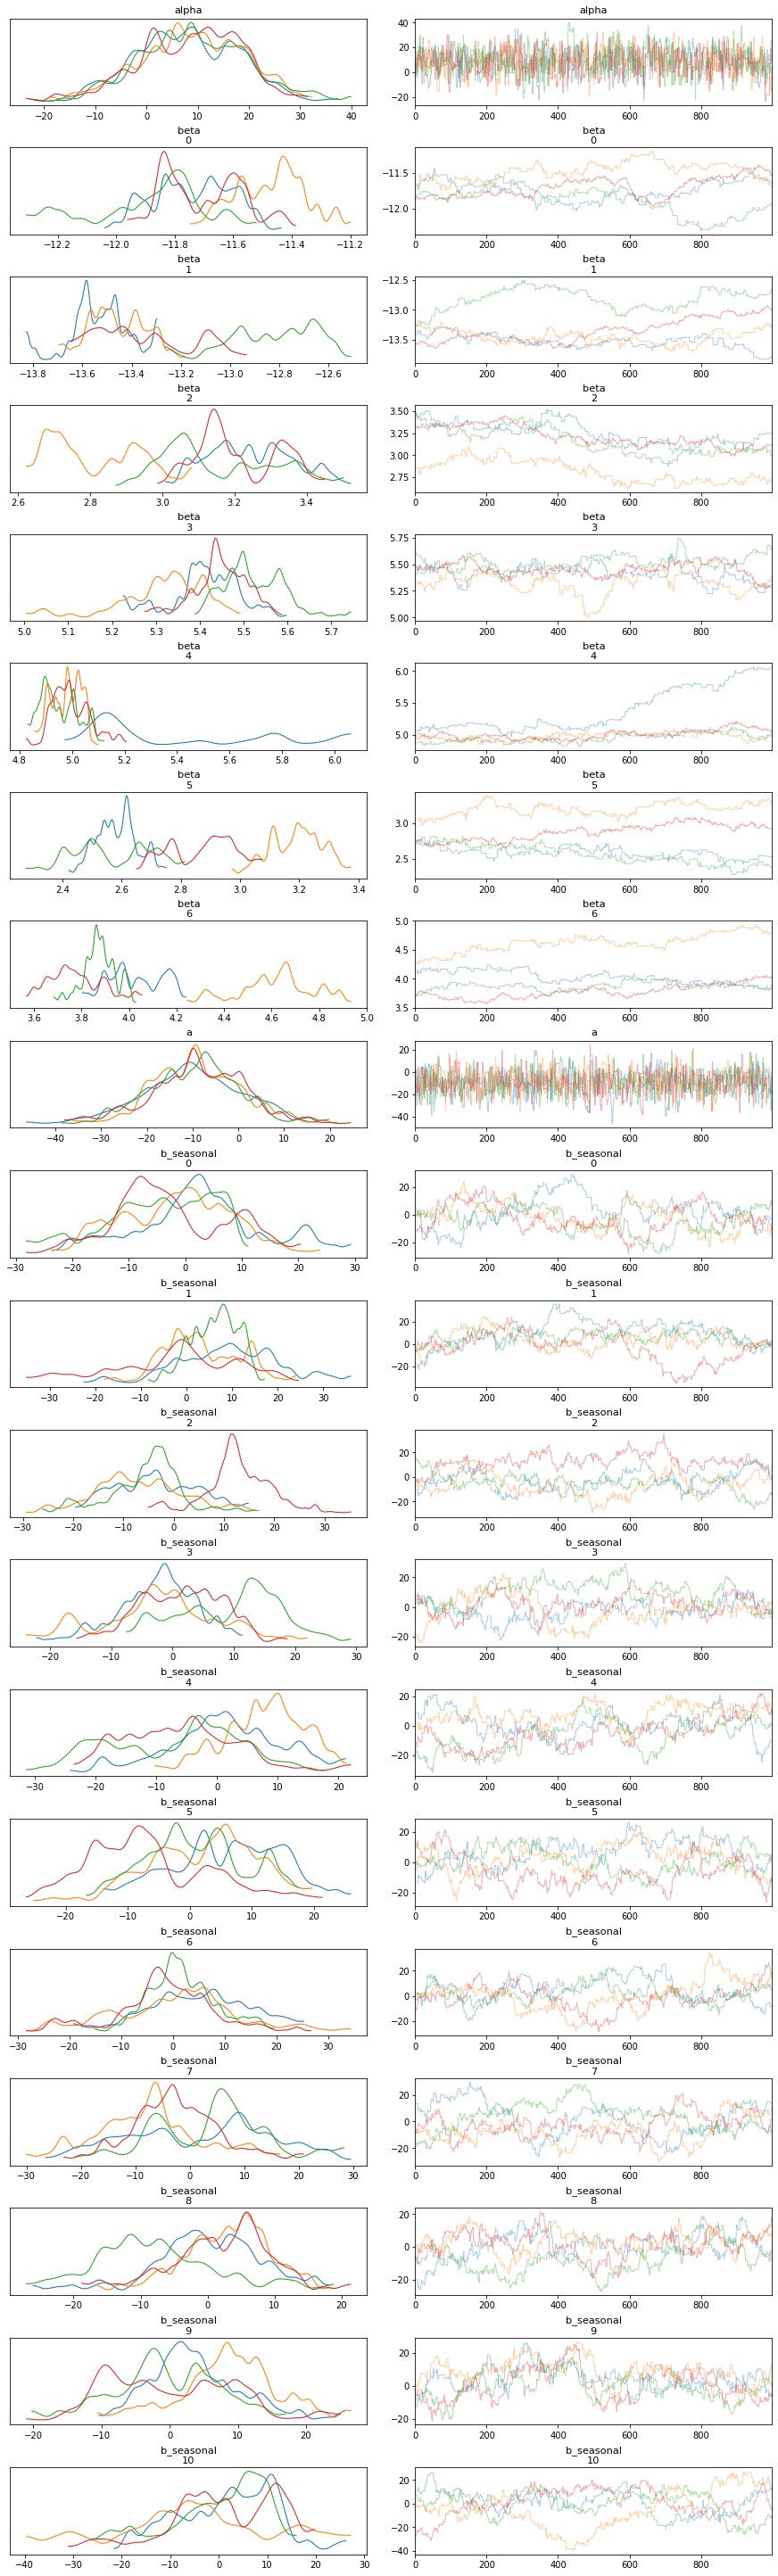

In [18]:
pm.traceplot(trace,compact=False)


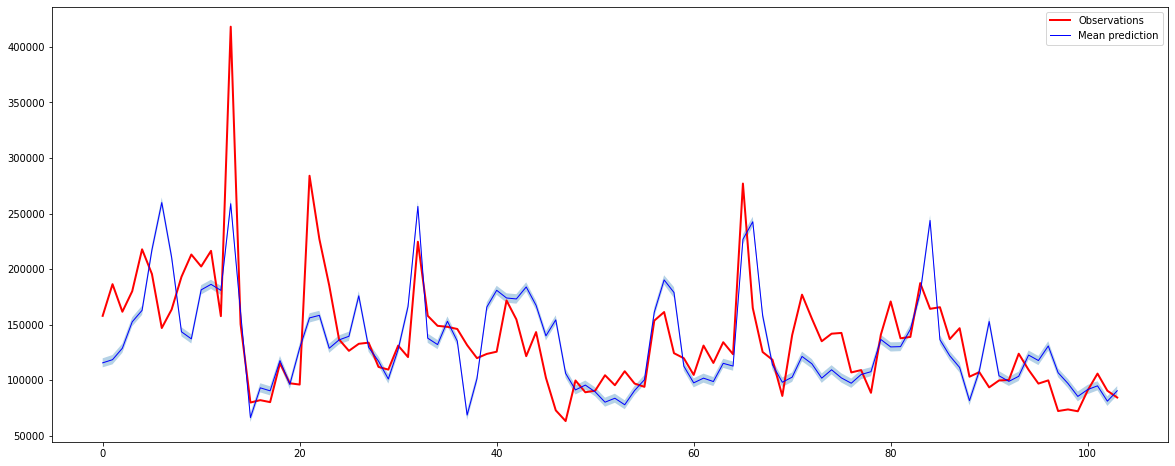

In [22]:
import matplotlib.pyplot as plt

with model:
    posterior = pm.sample_posterior_predictive(trace)

means = posterior['revenue'].mean(0)
stds = posterior['revenue'].std(0)

plt.figure(figsize=(20, 8))
plt.plot(data.revenue.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(data.revenue)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>,
        <Axes: title={'center': 'beta\n6'}>],
       [<Axes: title={'center': 'a'}>,
        <Axes: title={'center': 'b_seasonal\n0'}>,
        <Axes: title={'center': 'b_seasonal\n1'}>,
        <Axes: title={'center': 'b_seasonal\n2'}>],
       [<Axes: title={'center': 'b_seasonal\n3'}>,
        <Axes: title={'center': 'b_seasonal\n4'}>,
        <Axes: title={'center': 'b_seasonal\n5'}>,
        <Axes: title={'center': 'b_seasonal\n6'}>],
       [<Axes: title={'center': 'b_seasonal\n7'}>,
        <Axes: title={'center': 'b_seasonal\n8'}>,
        <Axes: title={'center': 'b_seasonal\n9'}>,
        <Axes: title={'center': 'b_seasonal\n10'}>],
       [<Axes: title={'center': 'b_s

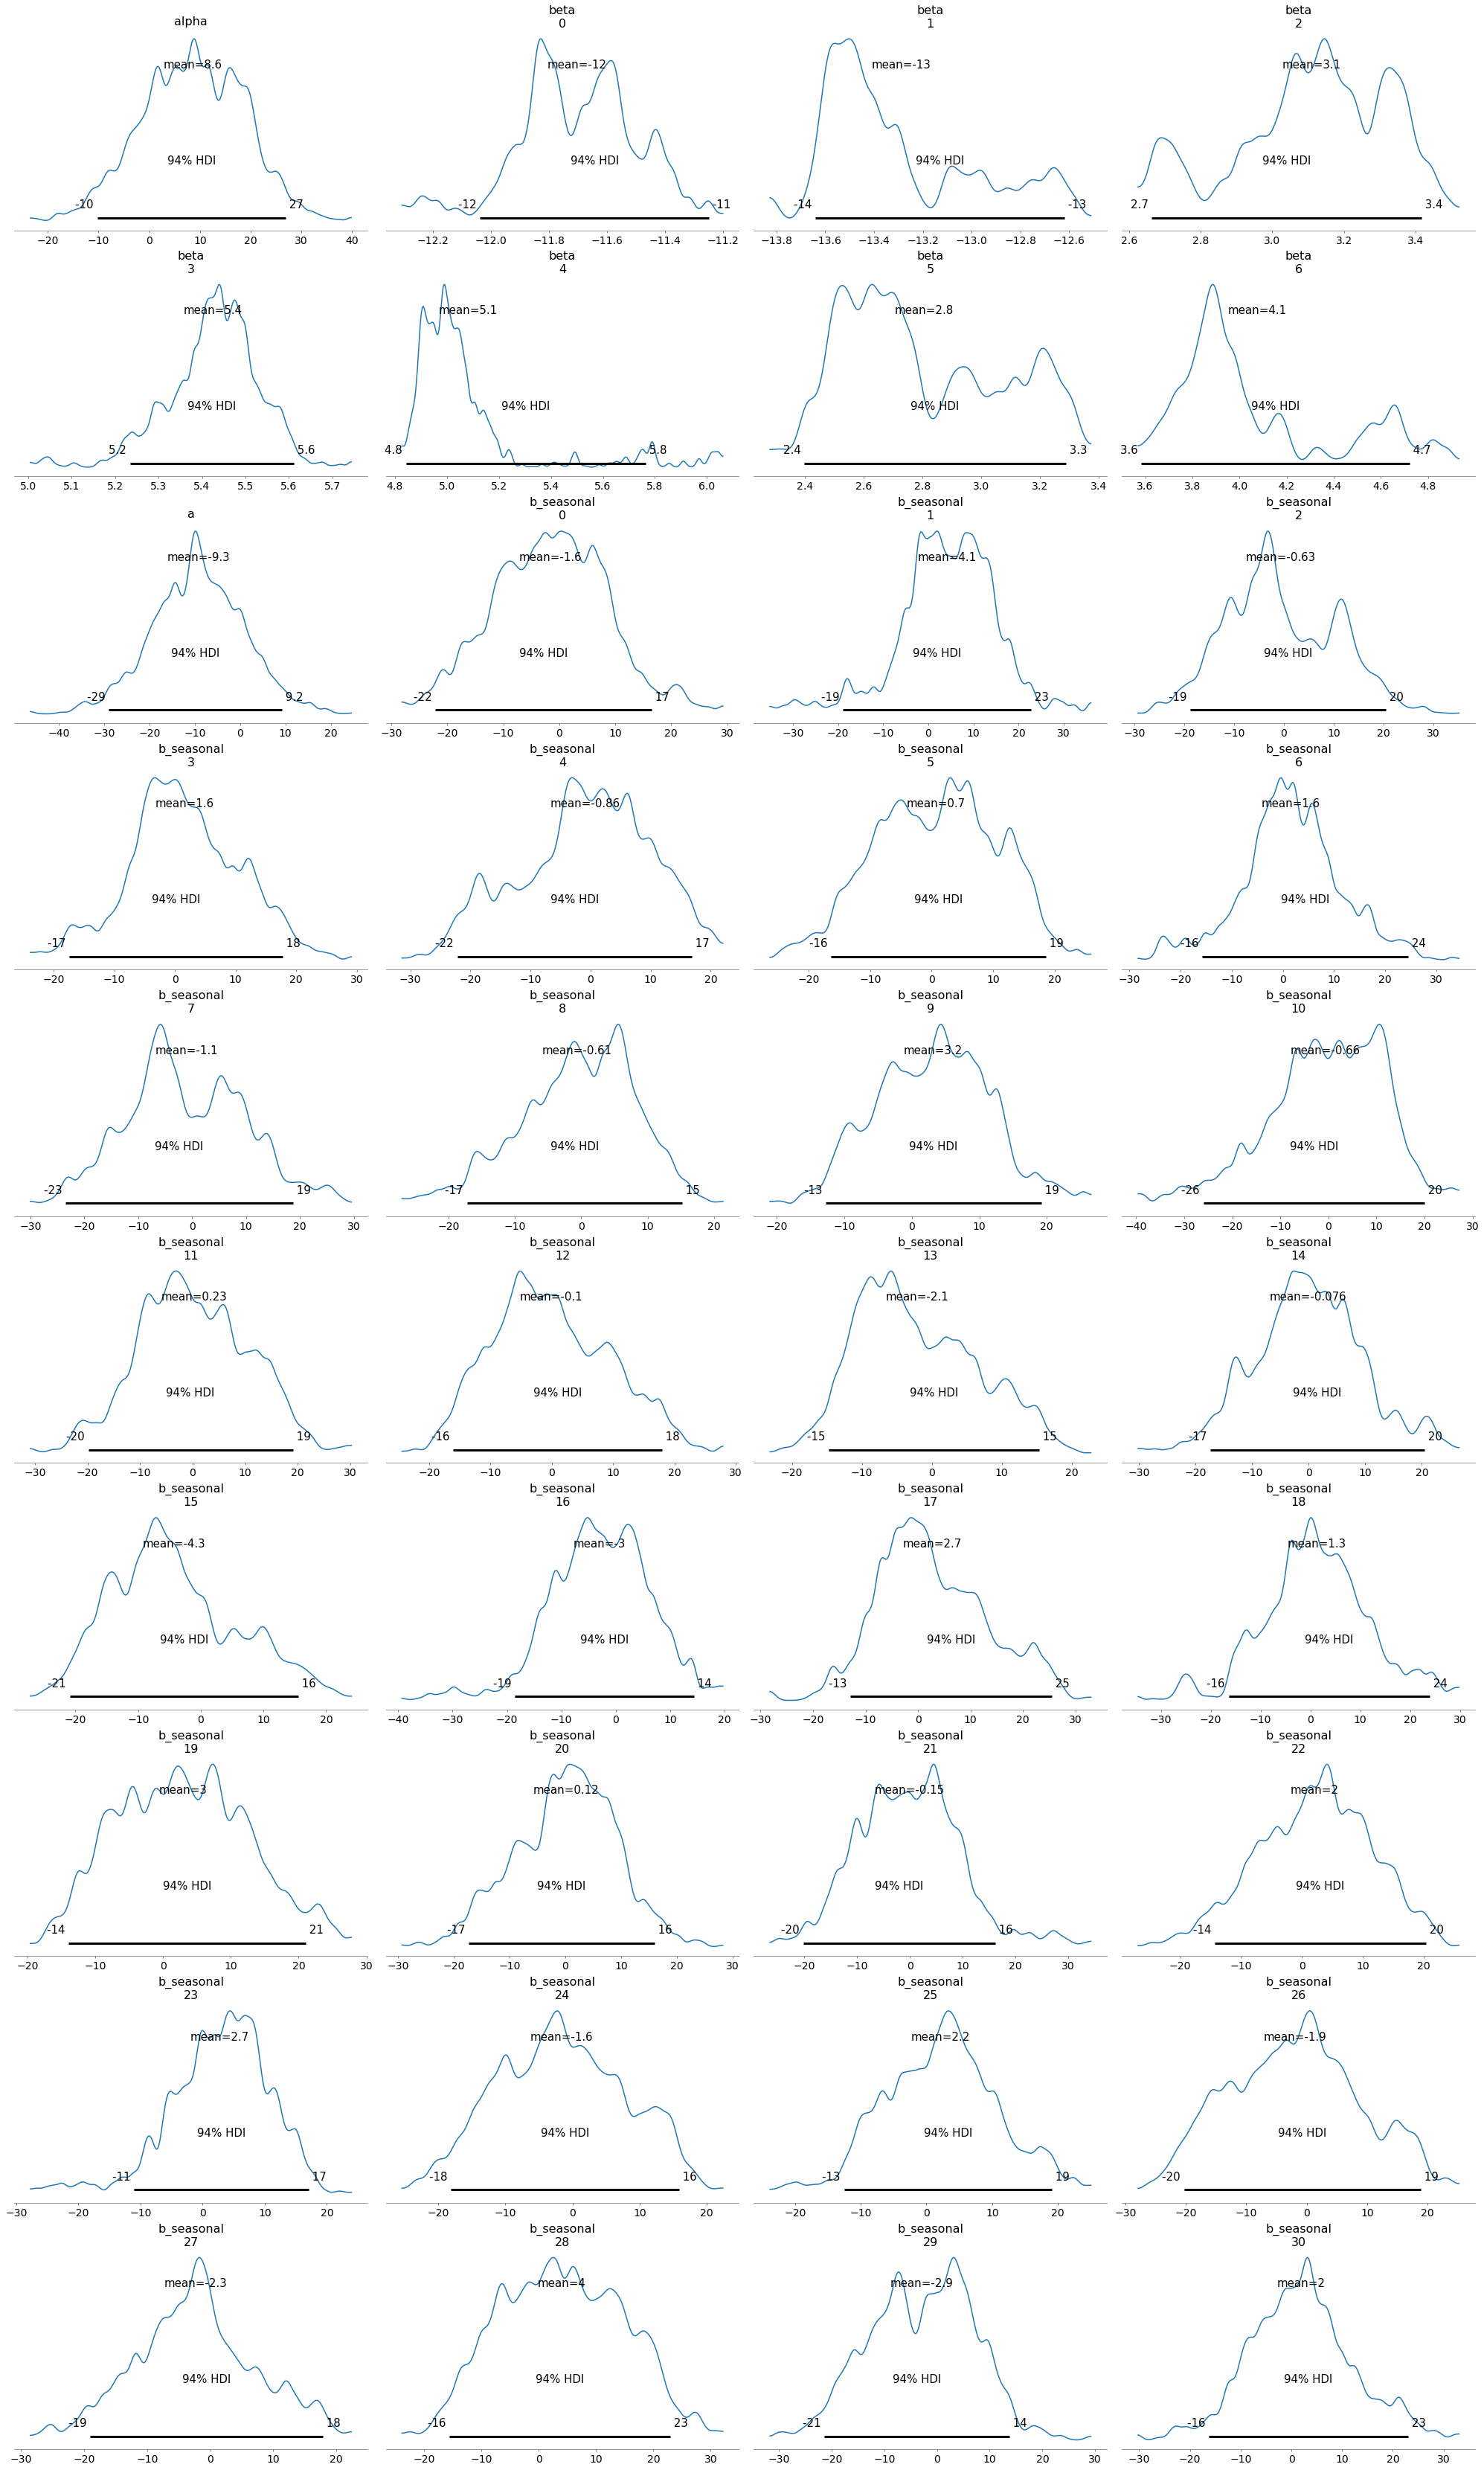

In [25]:
import arviz as az

az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like',
    grid = [10,4]
)